# 🗺️ Workshop 3 Image Classification

> 🌻 María Fernanda López
> 
> 🌻 Megan García Antivar

## 1. Obtención de imágenes satelitales

A continuación se procede a realizar la descarga de un mosaico **Sentinel-2** en este caso para una zona específica de la Amazonía con temporalidad de 2018 ± 1 año. De acuerdo con el artículo de González-González, Clerici y Quesada (2022).

In [1]:
pip install earthengine-api geemap geopandas

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 8.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 1.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 4.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━

El primer paso es la autenticación en Google Earth Engine. Antes de ejecutar cualquier código, es necesario asegurarse de reiniciar el kernel.

In [2]:
import ee
import geemap

# Solo la primera vez
ee.Authenticate()

# Inicia sesión en GEE
ee.Initialize()

Enter verification code:  4/1AUJR-x7KrXa5-qHHMMh0E4bhWttTLfzUu8LqQJkmRJIYKAr8URFb20h8mIg



Successfully saved authorization token.


A continuación se carga el shapefile, asegurándose que esté completo (`.shp`, `.shx`, `.dbf`, `.prj`) y en EPSG:4326. Luego usa este código para cargarlo:

In [39]:
import geopandas as gpd

# Cargar shapefile
gdf = gpd.read_file("/notebooks/Geoprocesamiento/Workshop/data/Workshop_3/ROI.shp")

# Asegúrate de que esté en EPSG:4326 (lat/lon)
gdf = gdf.to_crs(epsg=4326)

# Convertir a geojson
roi_json = gdf.geometry.union_all().__geo_interface__

# Crear geometría de EE
roi = ee.Geometry.Polygon(roi_json['coordinates']) if roi_json['type'] == 'Polygon' else ee.Geometry(roi_json)

Se realiza la función de enmascaramiento de nubes:

In [40]:
def maskS2clouds(image):
    # Select the QA60 band
    qa = image.select('QA60')

    # Bits 10 and 11 are cloud and cirrus confidence bands (1 == high confidence)
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask)

Se realiza la función de mosaico con los parámetros establecidos:

In [41]:
# Define the date range
start_date = '2017-01-01'
end_date = '2019-12-31'

bands_optical = ['B2', 'B3', 'B4', 'B5', 'B6',
                 'B7', 'B8', 'B8A', 'B11', 'B12'] 

# Load the Sentinel-2 image collection, filtered by date, bounds and cloudiness
#At the end you apply the function maskS2clouds to all the images in your iamge collection
#ad then it sorts by cloud cover
s2_img = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
          .filterBounds(roi)
          .filterDate("2018-01-01", "2018-12-31")  # cambiaste a 2018
          .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 50))
          .median()
          .select(bands_optical)
          .clip(roi))

Se obtiene la visualización del mosaico generado:

In [42]:
# Define the visualization parameters for displaying an image on the map.
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # True color (RGB)
    'min':100,
    'max': 5500,
    'gamma': 1.2,
}

#  Create an instance of an interactive map using the geemap library.
# geemap is a Python package for interactive mapping with Google Earth Engine (GEE).
Map = geemap.Map()

# Center the map on the Clipped image
Map.centerObject(roi, 12)

#Add the Sentinel-2 image (The clipped one)
Map.addLayer(s2_img, vis_params, 'Sentinel-2')

#Add the AOI
Map.addLayer(roi, {}, 'AOI')

#Show the map
Map

Map(center=[0.7438993852410466, -74.37883192530255], controls=(WidgetControl(options=['position', 'transparent…

A continuación se exporta la imagen a drive, para poder darle un manejo posterior.

In [43]:
task = ee.batch.Export.image.toDrive(
    image=s2_img,
    description='sentinel2',
    folder='Google Earth',
    fileNamePrefix='sentinel2_2018',
    region=roi,
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task.start()

## 2. Explicación de conceptos

Este notebook de Jupyter ofrece una experiencia práctica para aprender técnicas de clasificación de imágenes, tanto a nivel de píxeles como de objetos, utilizando las bibliotecas RSGISLib y scikit-learn. Está basado en los tutoriales creados por Pete Bunting. 

Durante el taller, se trabajará en las siguientes actividades:

1. **Preparación** de un conjunto reducido de imágenes Sentinel-2, incluyendo la combinación de bandas y el cálculo de índices espectrales.

2. **Entrenamiento** de modelos de Random Forest aplicados a datos por píxeles y por segmentos.

3. **Creación** de un mapa de cobertura del suelo utilizando reglas simples basadas en valores espectrales.

4. **Evaluación** de los resultados con un conjunto independiente de validación e interpretación de métricas de precisión.

Todos los productos generados —tanto intermedios como finales— se guardarán en formato **HDF5**, lo que facilita un manejo eficiente de los datos y permite incluir metadatos detallados.

---

### 📦 Qué es HDF5?

**HDF5 (Formato de Datos Jerárquico, versión 5)** es un estándar de archivo binario versátil diseñado para almacenar grandes volúmenes de datos científicos heterogéneos.

* **Estructura jerárquica**
Piensa en HDF5 como un sistema de archivos autosuficiente dentro de un solo archivo:

    * **Groups (Grupos)** = carpetas
    * **Datasets (Conjuntos de datos)** = archivos (matrices multidimensionales)
    * **Attributes (Atributos)** = metadatos tipo clave–valor adjuntos a grupos o conjuntos de datos

* **Características clave**  
  * Dimensiones ilimitadas (ideal para pilas de rásteres, series temporales, cubos hiperespectrales).  
  * **Compresión** incorporada (ej. `gzip`, `szip`), que ahorra espacio en disco sin archivos auxiliares externos.  
  * **Acceso aleatorio**: permite leer una pequeña porción sin cargar todo el archivo en memoria.  
  * **Seguro respecto al orden de bytes** (endianness)  y multiplataforma (Mac / Windows / Linux)  
  * Soporte nativo en Python (`h5py`, `xarray`), MATLAB, R, GDAL, QGIS y muchas bibliotecas de observación de la Tierra.

* **Por qué lo usamos aquí**  
  * Un solo archivo `.h5` almacena la imagen, las máscaras intermedias, las capas texturales **y** los resultados del modelo en un paquete portátil.  
  * Podemos adjuntar información de procedencia—nombre del sensor, fecha de adquisición, parámetros del clasificador—directamente en el archivo como atributos, garantizando que cualquier persona que abra los datos sepa exactamente cómo fueron generados.

---

### 👁️ Explorando archivos con HDFView**

Aunque los scripts en Python son perfectos para la automatización, un visor gráfico es invaluable cuando se trabaja por primera vez con un archivo HDF5 desconocido.  
Usaremos **HDFView** (el visor oficial del HDF Group):

1. **Descarga e instalación**  
   *Última versión*: <https://www.hdfgroup.org/download-hdfview/>  
   Elige el instalador para tu sistema operativo; el entorno Java viene incluido.

2. **Abrir un archivo**  
   *Archivo → Abrir* → selecciona `tu_dataset.h5`.  
   El panel izquierdo muestra el árbol de **grupos** y **conjuntos de datos**; el panel derecho previsualiza el contenido.

3. **Explorar los datasets**  
   * Haz doble clic sobre un dataset para ver los valores de la matriz.  
   * Usa la pestaña *Tabla* o *Imagen* para cambiar el modo de visualización (útil para rásteres 2D).  
   * Clic derecho → *Mostrar propiedades* para inspeccionar **atributos** (por ejemplo: sistema de referencia, longitud de onda).

4. **Ventajas para la enseñanza**  
   * Los estudiantes pueden **visualizar fácilmente** la estructura jerárquica y los metadatos sin escribir ni una línea de código.  
   * Revisión rápida del contenido (dimensiones, valores mínimos y máximos) antes de usar los datos en un modelo.  
   * Exportar fragmentos a CSV o PNG para usar en presentaciones.

---

### 📝 Metadatos que puedes registrar

| Categoría | Clave de atributo sugerida | Ejemplo de valor |
|----------|------------------------|---------------|
| Adquisición | `sensor`, `acq_date` | `"Sentinel-2 MSI"`, `"2024-07-12"` |
| Preprocesamiento | `atm_corr`, `indices` | `"Sen2Cor 2.10"`, `"NDVI, NDWI, NDBI"` |
| Detalles del clasificador | `model_type`, `rf_n_estimators`, `rf_max_depth` | `"RandomForest"`, `300`, `12` |
| Validación | `oa`, `kappa`, `macro_f1` | `0.88`, `0.84`, `0.85` |

Añadir atributos en Python con **h5py**:

```python
import h5py
with h5py.File("classified_map.h5", "a") as f:
    f.attrs["sensor"] = "Sentinel-2 MSI"
    f["/classification"].attrs["model_type"] = "RandomForest"

## 3. Importar módulos

In [54]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas and numpy for vector analysis (https://geopandas.org)
import geopandas
import numpy as np

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.imageutils
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

# Import rasterio
import rasterio

## 4. Asignar los datos de entrada a variables

### Crear una máscara

In [61]:
# Abrir la imagen base solo para obtener dimensiones y metadata
input_img = 'data/Workshop_3/sentinel2_2018.tif'

with rasterio.open(input_img) as src:
    shape = (src.height, src.width)
    profile = src.profile

# Crear máscara binaria con todo a 1 (válido)
mask = np.ones(shape, dtype=np.uint8)

# Actualizar metadata para que sea archivo de una sola banda
profile.update({
    "count": 1,
    "dtype": 'uint8',
    "nodata": 0  # define explícitamente qué es inválido
})

# Guardar como GeoTIFF
with rasterio.open("data/Workshop_3/sentinel2_2018_vmask.tif", "w", **profile) as dst:
    dst.write(mask, 1)

### Proyectar los datos

In [56]:
output_img = "data/Workshop_3/sentinel2_2018_epsg3116.tif"

rsgislib.imageutils.gdal_warp(
    input_img=input_img,
    output_img=output_img,
    out_epsg=3116,
    interp_method=rsgislib.INTERP_BILINEAR,  # o BILINEAR si son valores continuos
    gdalformat="GTiff",
    use_multi_threaded=True,
    options=["TILED=YES", "COMPRESS=LZW", "BIGTIFF=YES"]
)

102it [00:30,  3.31it/s]                                                                                                


In [57]:
mask_img = "data/Workshop_3/sentinel2_2018_vmask.tif"
output_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"

rsgislib.imageutils.gdal_warp(
    input_img=mask_img,
    output_img=output_img,
    out_epsg=3116,
    interp_method=rsgislib.INTERP_BILINEAR,  # o BILINEAR si son valores continuos
    gdalformat="GTiff",
    use_multi_threaded=True,
    options=["TILED=YES", "COMPRESS=LZW", "BIGTIFF=YES"]
)

102it [00:01, 78.61it/s]                                                                                                


In [58]:
# Ruta original y destino
input_gpkg = "data/Workshop_3/Training_data.gpkg"
output_gpkg = "data/Workshop_3/Training_data_epsg3116.gpkg"

# Leer archivo original
gdf = gpd.read_file(input_gpkg)

# Reproyectar a MAGNA-SIRGAS / Colombia Bogotá
gdf_3116 = gdf.to_crs(epsg=3116)

# Guardar como nuevo GPKG
gdf_3116.to_file(output_gpkg, driver="GPKG")

In [74]:
input_img = "data/Workshop_3/sentinel2_2018_epsg3116.tif"
in_msk_img = "data/Workshop_3/sentinel2_2018_vmask_3116.tif"
vec_train_file = "data/Workshop_3/Training_data_epsg3116.gpkg"

In [60]:
# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(input_img)
print(f"Image Resolution: ({round(x_res, 2)}, {round(y_res,2)}) m")

Image Resolution: (9.98, -9.98) m


In [63]:
# Call function to get the input image resolution:
x_res, y_res = rsgislib.imageutils.get_img_res(in_msk_img)
print(f"Image Resolution: ({round(x_res, 2)}, {round(y_res,2)}) m")

Image Resolution: (9.98, -9.98) m


Declara las entradas principales para el ejercicio de clasificación:

| Variable         | Archivo                                                 | Propósito                                                                                                                                                                                                                                                              |
| ---------------- | ------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `input_img`      | `sentinel2_2018_epsg3116.tif`      | Escena multiespectral Sentinel-2 (resolución espacial de 9.98 m) que será clasificada. El archivo ya ha sido corregido a reflectancia de superficie y está proyectado al sistema de coordenadas colombiano (EPSG 3116).                                            |
| `in_msk_img`     | `sentinel2_2018_vmask_3116.tif` | Máscara de píxeles válidos para la misma escena. Identifica los píxeles que deben ser ignorados (nubes, bordes, huecos del detector). Para este subconjunto, todos los píxeles resultan ser válidos, pero las rutinas de RSGISLib aún requieren una máscara explícita. |
| `vec_train_file` | `Training_data_epsg3116.gpkg`                           | Capa vectorial que contiene los puntos de entrenamiento (o pequeños polígonos). Cada registro está etiquetado con un ID de clase de cobertura del suelo; los valores espectrales bajo estos puntos entrenarán el clasificador Random Forest y SVM.                           |


> #### **¿Por qué molestarse en usar una máscara?**
> Incluso cuando toda la imagen parece válida, muchas cadenas de procesamiento de observación de la Tierra esperan una máscara complementaria para poder manejar sin problemas escenas con nubes o líneas faltantes. Proporcionar una ahora asegura que el mismo flujo de trabajo exacto funcione más adelante sobre imágenes menos limpias.

Las muestras se definen utilizando capas vectoriales de polígonos. Cada atributo representa una clase, y dentro de esa capa se utilizan múltiples polígonos o puntos para identificar los píxeles que pertenecen a la clase de interés. Ten en cuenta que la capa vectorial debe estar en la misma proyección que la(s) imagen(es) de entrada. 

Recuerda que, al definir tu conjunto de datos de referencia, debes asegurarte de obtener un número similar de píxeles muestreados para todas las clases. Esto puede ser problemático para clases que tienen una cobertura geográfica limitada. Sin embargo, también debes procurar tener una buena cobertura geográfica y evitar tener pocos polígonos grandes todos ubicados en una misma zona — esto puede resultar en una sobreestimación de la precisión del clasificador debido al sobreajuste causado por autocorrelación espacial.

Para este análisis, se utilizará el siguiente archivo Geopackage (GPKG) que contiene una capa que definen los datos de entrenamiento. Abre las capas en un SIG y examínalas antes de continuar con el tutorial. Después de terminar el tutorial, podrías considerar revisar estos datos de referencia, volver a ejecutar las clasificaciones y comparar los resultados para ver qué diferencia produce.

## 5. Explorar los datos

### Exportar cada una de las clases a una única capa

Para seguir el ejercicio es correcto que cada una de las clases de coberturas este en una sola capa. Por ello, a continuación se procede a extraer esta información.

In [67]:
# Leer la capa original
gdf = gpd.read_file("data/Workshop_3/Training_data_epsg3116.gpkg", layer="training_data_epsg3116")

print(gdf.columns)
print(gdf["Name"].unique())

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'landcover',
       'system_ind', 'geometry'],
      dtype='object')
['Water_bodies' 'Agricultural_areas' 'sparsely or no vegetated areas'
 'Forest' 'Secondary_vegetation']


In [71]:
# Ruta de salida
output_gpkg = "data/Workshop_3/Training_data_epsg3116.gpkg"

# Nombre de la columna que contiene las clases
clase_col = "Name" 

# Iterar por clase y guardar como capa individual
for clase in gdf[clase_col].unique():
    sub_gdf = gdf[gdf[clase_col] == clase]
    sub_gdf.to_file(output_gpkg, layer=clase.replace(" ", "_"), driver="GPKG")

Obtén la lista de capas dentro del archivo vectorial:

In [72]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Training_data_epsg3116', 'Water_bodies', 'Agricultural_areas', 'sparsely_or_no_vegetated_areas', 'Forest', 'Secondary_vegetation']


### Visualizar los datos de entrenamiento

Se recomienda abrir la imagen de entrada (sentinel2_2018.tif) y las muestras de entrenamiento (vec_train_file.gpkg) en QGIS (u otro visor SIG) para observar las regiones que han sido definidas para el entrenamiento, ya que esto te permite navegar (hacer pan y zoom) de forma más libre sobre los datos.

Sin embargo, a continuación se muestra una visualización general a modo ilustrativo. Si modificas el bounding box, puedes desplazarte y acercarte dentro de la escena. Ten en cuenta que las muestras de entrenamiento son bastante pequeñas en comparación con toda la escena y por eso pueden ser difíciles de ver.

In [75]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133)


La siguiente celda crea un único mapa que superpone nuestro **mosaico de Sentinel-2** con los **puntos o polígonos de entrenamiento**. El objetivo es confirmar que cada muestra realmente se encuentra sobre su tipo de cobertura del suelo correspondiente.

* **📦 Cuadro delimitador (Bounding box)**

Recorta la visualización al área `sub_img_bbox = [953958.66, 978958.66, 561527.23, 586527.23]` (mín-x, máx-x, mín-y, máx-y en metros). Esta ventana de 25 km × 25 km mantiene la figura compacta, pero aún así abarca todas las capas de entrenamiento.

* **🛰️ Imagen base (bandas 8-9-3)**

`rsgislib.tools.mapping.create_raster_img_map` dibuja una composición pseudo-RGB utilizando las bandas 8 (NIR), 9 (borde rojo) y 3 (verde) de Sentinel-2. Se aplica un estiramiento de histograma acumulado para mejorar el contraste local, y se añade automáticamente una barra de escala.

* **🎨 Colores aleatorios para cada clase de cobertura**

Se obtiene toda la paleta CSS4 de Matplotlib (`mcolors.CSS4_COLORS`) y se asigna un color aleatorio distinto a cada capa listada en lyr_names. Esto garantiza que las clases sean visualmente distinguibles sin necesidad de elegir colores manualmente.

* **📚 Carga de las capas de entrenamiento**

Cada capa del archivo `vec_train_file` (GeoPackage o Shapefile) se carga en un GeoDataFrame de GeoPandas, y se almacena en gp_vecs, lista para ser graficada.

* **🗺️ Superposición vectorial**
  
`create_vec_lyr_map` dibuja todas las capas de entrenamiento en un solo comando, utilizando los colores aleatorios seleccionados y un borde negro delgado. El bounding box asegura que la superposición coincida perfectamente con el subset del ráster. La segunda barra de escala se suprime para evitar saturación visual.

**¿Por qué hacer esto?**

Antes de ejecutar cualquier algoritmo de aprendizaje automático, debemos asegurarnos de que:

1. El subset de la imagen realmente cubre todos los puntos de entrenamiento.
2. Ninguna muestra cae sobre nubes, artefactos de borde o fuera de la máscara de píxeles válidos.
3. La composición espectral se ve razonable (sin bandas desalineadas, estiramiento correcto).

Una inspección rápida de esta figura puede ahorrar mucho tiempo de procesamiento malgastado más adelante.

> **🔍 Experimenta con combinaciones de bandas:**

>Cambia `img_bands = [8, 9, 3]` por otro trío, por ejemplo: `[11, 8, 4]` (SWIR–NIR–Rojo) o `[12, 11, 4]` y observa cómo se comportan la vegetación, las áreas urbanas y los cuerpos de agua.

En `gpd.read_file`, el argumento layer le indica a GeoPandas qué capa vectorial del archivo se debe cargar. Un Shapefile solo contiene una capa, por lo que layer= es ignorado.

Un GeoPackage (.gpkg) o archivo MapInfo TAB puede contener varias capas, es decir, múltiples conjuntos de datos dentro de un solo contenedor. Por eso, debes especificar cuál deseas cargar.

En este notebook, `lyr_names` es una lista de cadenas, cada una con el nombre exacto de una capa específica por clase dentro del archivo `vec_train_file`.

Image Data Size: 4360 x 3288


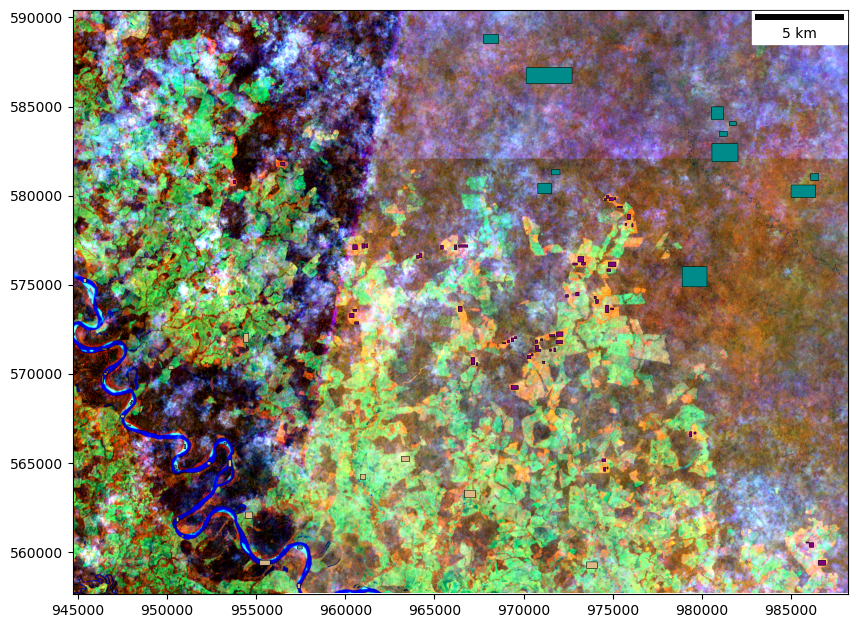

In [81]:
# ---------------------------------------------------------
# 1. Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [944712.7306693317, 988204.5931766616, 557628.0093751058, 590426.4598164133]
# ---------------------------------------------------------
# 2. Prepare a Matplotlib canvas
#    One axis, 10 × 10 inches – large enough for legible detail.
fig, ax = plt.subplots(figsize=(10, 10))
# ---------------------------------------------------------
# 3. Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
# ---------------------------------------------------------
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# ---------------------------------------------------------
# 4. Build a palette of distinct colours
#    CSS4 provides ~140 named colours; we convert the dict keys
#    to a list so random.choice can pick from it.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# ---------------------------------------------------------
# 5. Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(geopandas.read_file(vec_train_file, layer=lyr_name))
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# ---------------------------------------------------------
# 6. Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
# ---------------------------------------------------------
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)

## 6. Extraer muestras de entrenamiento

Para el análisis, los valores individuales de los píxeles se extraen y se almacenan en un archivo HDF5, lo que permite guardar y manipular esos datos (por ejemplo, los valores de píxeles provenientes de múltiples imágenes pueden combinarse).

Para extraer las muestras de entrenamiento (es decir, los valores individuales de los píxeles) utilizando la capa vectorial definida, primero es necesario rasterizar las capas vectoriales para que coincidan con la misma cuadrícula de píxeles de la(s) imagen(es) de entrada. Para simplificar este proceso, se ha proporcionado una función auxiliar:
`rsgislib.classification.get_class_training_data`.

### Definir imágenes y bandas para la clasificación

Antes de poder extraer los valores de los píxeles o realizar la clasificación, es necesario definir las imágenes relevantes y las bandas dentro de esas imágenes. Es fundamental que estas definiciones sean idénticas tanto para la extracción de las muestras como para el paso de clasificación.

Si no se definen de manera idéntica, el clasificador entrenado no funcionará como se espera, lo que probablemente resultará en muy malos resultados de clasificación.

Para definir las imágenes y bandas, se proporciona una lista de objetos `rsgislib.imageutils.ImageBandInfo` a las funciones correspondientes de RSGISLib.
Consulta el [enlace](http://rsgislib.org/rsgislib_imageutils.html#rsgislib.imageutils.ImageBandInfo) para entender mejor la clase `rsgislib.imageutils.ImageBandInfo`.

In [82]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'data/Workshop_3/sentinel2_2018_epsg3116.tif')]


### Definir las clases y las muestras vectoriales

La rutina auxiliar de Random Forest espera una **lista de objetos `ClassVecSamplesInfoObj`** —uno por cada clase de cobertura del suelo. Cada objeto le indica a RSGISLib dónde obtener los vectores de entrenamiento y dónde almacenar los valores de los píxeles extraídos.

| Parámetro    | Significado                                                                                                                                                  | Nota práctica |
| ------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------- |
| `id`         | Etiqueta entera que se escribirá en el ráster clasificado. Mantén la secuencia compacta (por ejemplo, del 1 al 10) para facilitar la reasignación posterior. |               |
| `class_name` | Nombre corto, legible por máquina (en minúsculas y con guiones bajos). Se usa como nombre de grupo dentro del archivo HDF5 de muestras.                      |               |
| `vec_file`   | Ruta al archivo GeoPackage que contiene todas las capas de entrenamiento.                                                                                    |               |
| `vec_lyr`    | Nombre exacto de la capa dentro del GeoPackage para esta clase.                                                                                              |               |
| `file_h5`    | Nombre del archivo HDF5 que RSGISLib creará para almacenar las muestras de píxeles extraídas (un archivo por clase mantiene el orden).                       |               |

La siguiente celda instancia cinco objetos de este tipo —uno por cada clase temática de nuestra leyenda— y los agrega a la lista `class_vec_sample_info`.

Puedes agregar o eliminar entradas libremente, siempre que los IDs sean únicos y los nombres de las capas vectoriales coincidan exactamente con los que están en el archivo GeoPackage.

In [83]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="Agricultural_areas",
        vec_file=vec_train_file,
        vec_lyr="Agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
forest_h5 = "forest_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="Forest",
        vec_file=vec_train_file,
        vec_lyr="Forest",
        file_h5=forest_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="Secondary_vegetation",
        vec_file=vec_train_file,
        vec_lyr="Secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
sparsely_no_veg_h5 = "sparsely_no_veg_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="sparsely or no vegetated areas",
        vec_file=vec_train_file,
        vec_lyr="sparsely_no_veg",
        file_h5=sparsely_no_veg_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="Water_bodies",
        vec_file=vec_train_file,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)

## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x73ee5da22fd0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x73ee5cba8910>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x73ee5cd2fc90>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x73ee5cbd6250>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x73ee5cbd4d10>]


Cuando haces `print()` sobre un objeto `ClassVecSamplesInfoObj`, solo obtienes la salida predeterminada de Python: `<rsgislib.classification.ClassVecSamplesInfoObj object at 0x…>`, lo cual no es más que la dirección de memoria del objeto. Para ver el **contenido real del objeto**, necesitamos consultar sus atributos directamente.

El siguiente bloque de código:

1. Almacena la primera entrada de la lista (`class_vec_sample_info[0]`) en una variable llamada `obj`.
2. Llama a `**vars(obj)**` (o, de forma equivalente, `obj.__dict__)` para mostrar todos sus atributos como un diccionario de Python ordenado.

Esto permite ver con total claridad qué `id`, `class_name`, capa vectorial y nombre de archivo HDF5 están asociados con esa clase de entrenamiento.

In [84]:
obj = class_vec_sample_info[0]
vars(obj)        # returns a dictionary of attributes
# or
obj.__dict__

{'id': 1,
 'class_name': 'Agricultural_areas',
 'vec_file': 'data/Workshop_3/Training_data_epsg3116.gpkg',
 'vec_lyr': 'Agricultural_areas',
 'file_h5': 'agricultural_areas_smpls.h5'}

**¿Qué hace realmente `obj.__dict__`?**

Todo objeto "normal" en Python mantiene sus **atributos de instancia** en un diccionario oculto llamado `__dict__`.
Cuando accedes o asignas `obj.algun_atributo`, Python en realidad está haciendo una búsqueda o actualización dentro de ese diccionario.

Por lo tanto, al llamar a `obj.__dict__` se devuelve un `diccionario` activo que contiene todos los atributos definidos por el usuario y sus valores actuales:

```python
{
    'id'        : 1,
    'class_name': 'Agricultural_areas',
    'vec_file'  : 'data/Workshop_3/Training_data_epsg3116.gpkg',
    'vec_lyr'   : 'Agricultural_areas',
    'file_h5'   : 'agricultural_areas_smpls.h5'
}